In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv("gold_monthly_csv.csv")
df.head()


,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [4]:
df.shape

(847, 2)

In [5]:
print(f"date of gold proces vailable from -{df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")

date of gold proces vailable from -1950-01 to 2020-07


In [6]:
date = pd.date_range (start= '1/1/1950', end='8/1/2020', freq = 'M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [7]:
df['month'] = date
df.drop('Date', axis = 1, inplace= True)
df = df.set_index('month')

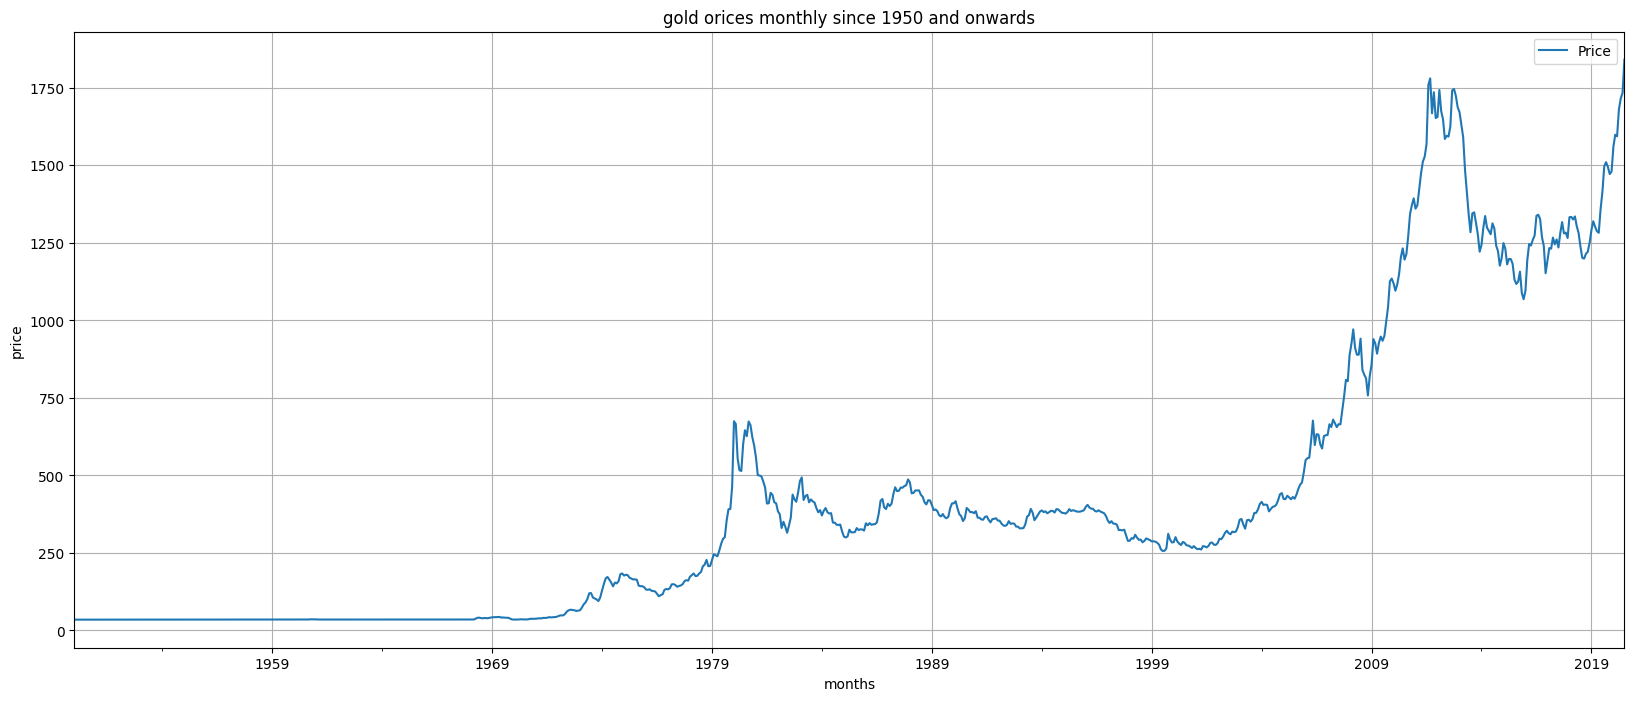

In [8]:
df.plot(figsize=(20,8))
plt.title("gold orices monthly since 1950 and onwards")
plt.xlabel("months")
plt.ylabel('price')
plt.grid();


In [9]:
round(df.describe(),3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


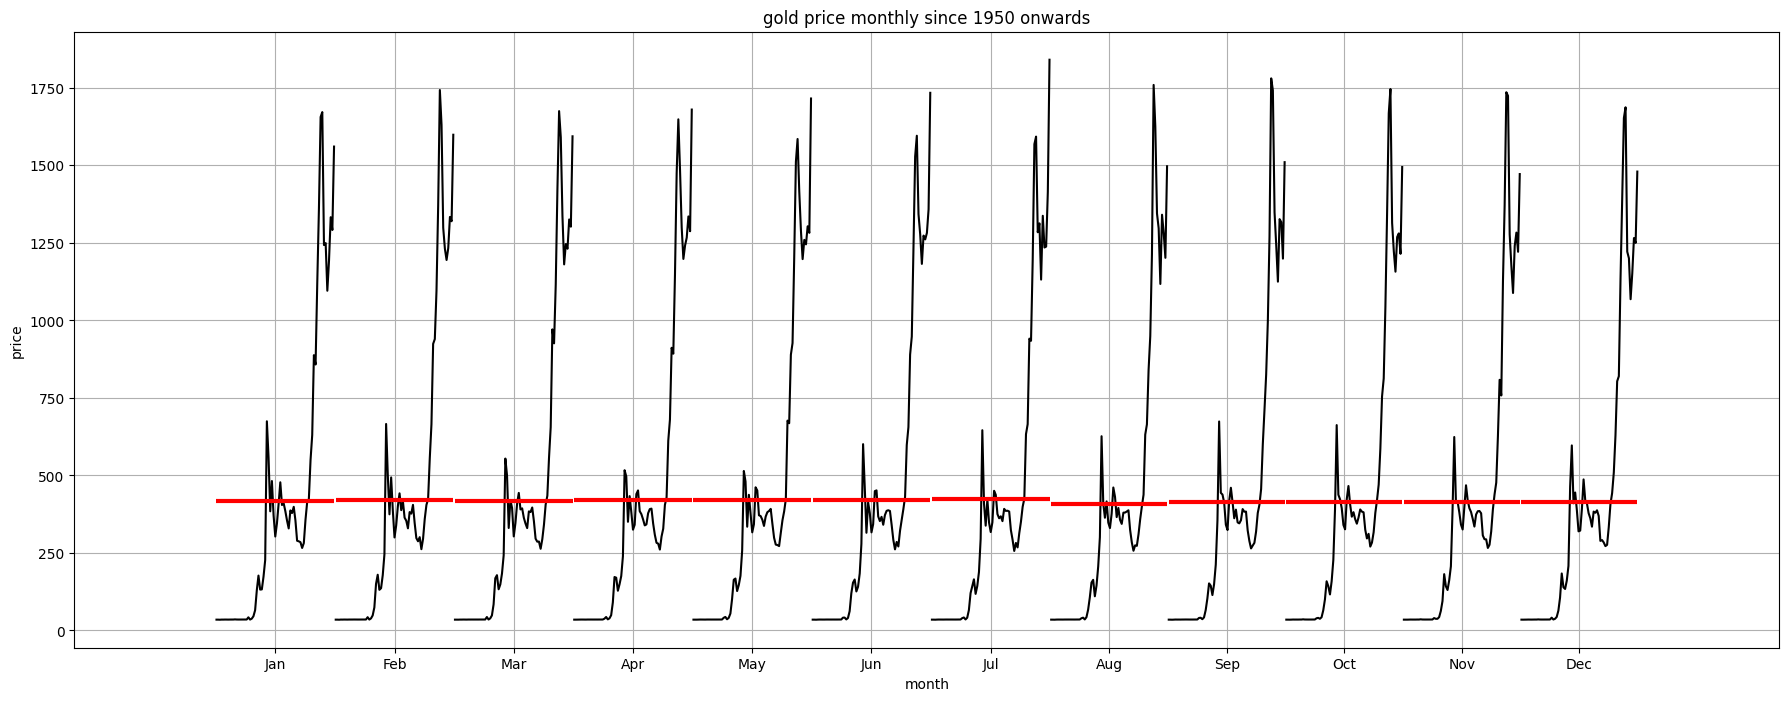

In [11]:
from statsmodels.graphics.tsaplots import month_plot

fig, ax = plt.subplots(figsize=(22,8))
month_plot(df, ylabel = 'gold price', ax= ax)
plt.title('gold price monthly since 1950 onwards')
plt.xlabel('month')
plt.ylabel('price')
plt.grid();


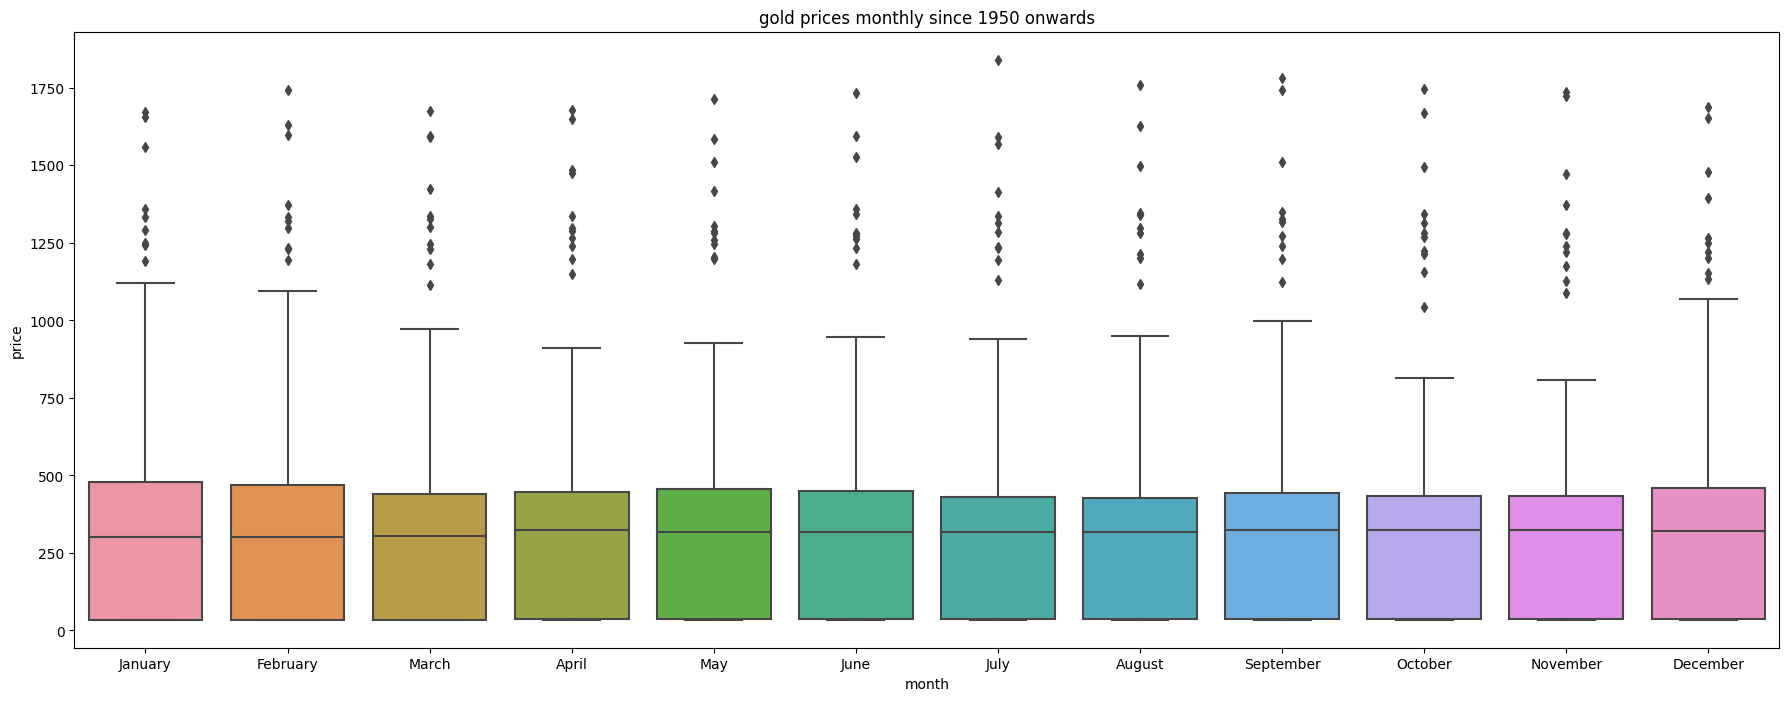

In [12]:
_, ax= plt.subplots(figsize=(22, 8))
sns.boxplot(x = df.index.month_name(), y = df.values[:, 0], ax= ax)
plt.title('gold prices monthly since 1950 onwards')
plt.xlabel("month")
plt.ylabel('price')
plt.show();

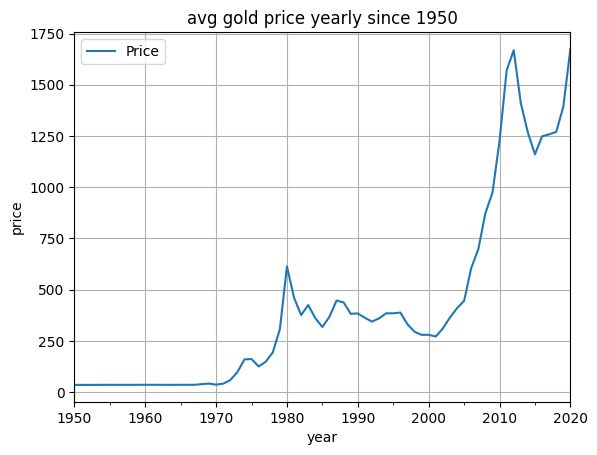

In [13]:
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot();
plt.title("avg gold price yearly since 1950")
plt.xlabel('year')
plt.ylabel('price')
plt.grid();

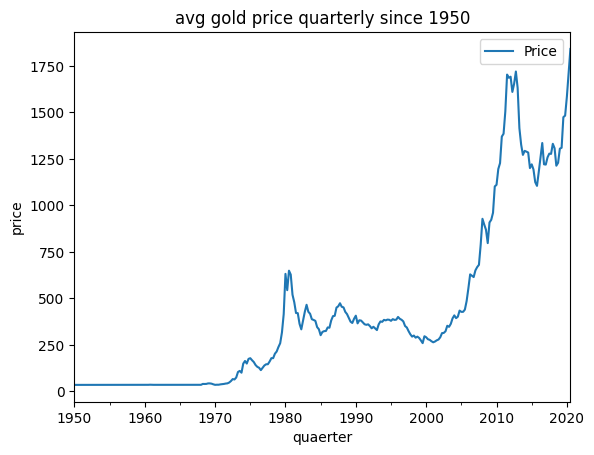

In [14]:
df_quarterly_sum = df.resample('Q').mean()
df_quarterly_sum.plot();
plt.title("avg gold price quarterly since 1950")
plt.xlabel('quaerter')
plt.ylabel('price')
plt.show();


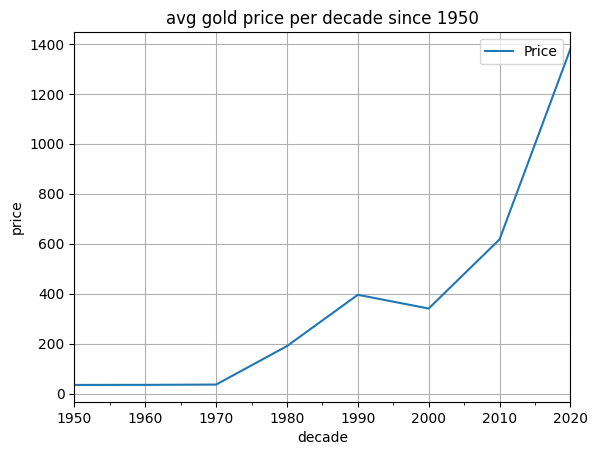

In [15]:
df.decade_sum = df.resample('10y').mean()
df.decade_sum.plot();
plt.title('avg gold price per decade since 1950')
plt.xlabel('decade')
plt.ylabel('price')
plt.grid();


In [24]:
# coefficient of varitaion(CV value) (data series aroun the mean)( lowwer the ratio of std variation to mean betetr is the trade of )
df_1 = df.groupby(df.index.year).mean().rename(columns={'Price':'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price':'Std'}), left_index = True, right_index = True)
df_1['Cov_pct'] = ((df_1['Std']/df_1["Mean"])*100).round(2)
df_1.head()



,Mean,Std,Cov_pct
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


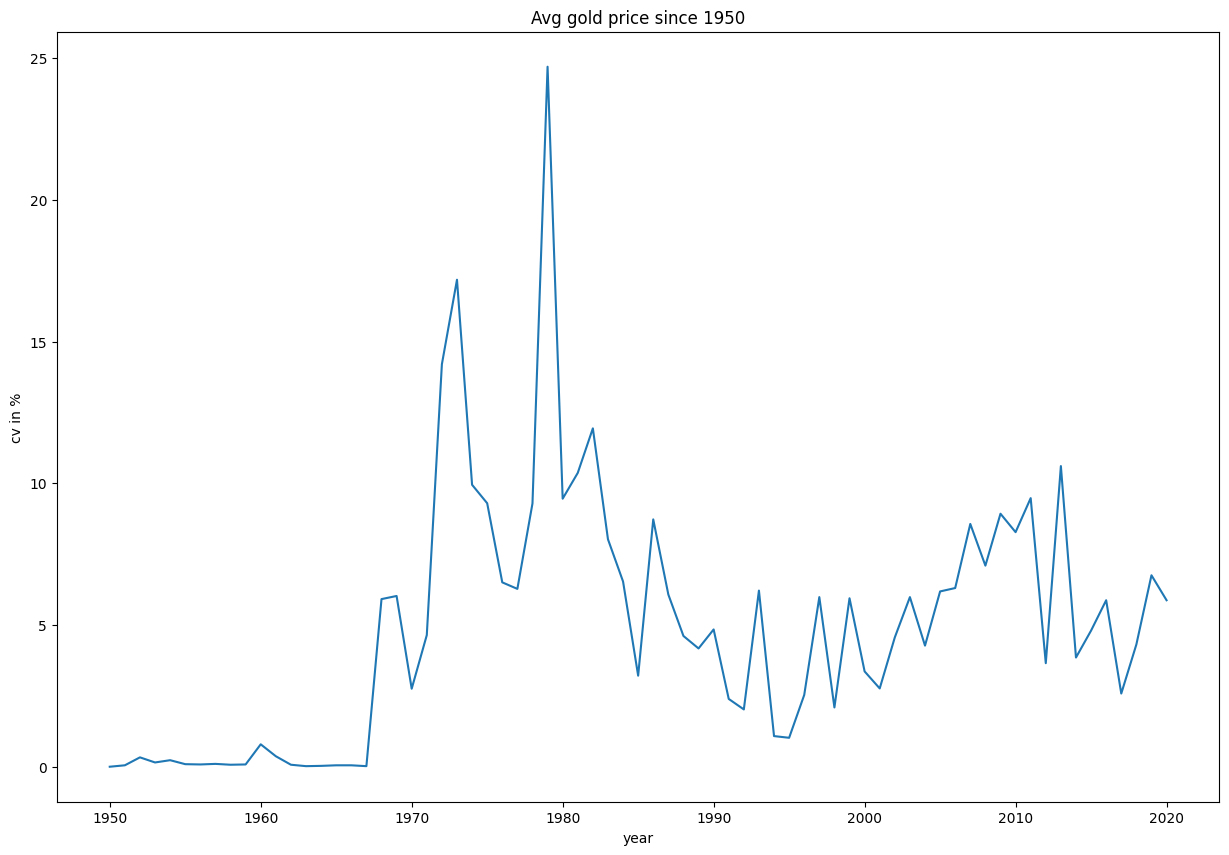

In [33]:
#fig, ax = plt.subplots(figsize=(22,8))
fig, ax= plt.subplots(figsize= (15,10))
df_1['Cov_pct'].plot();
plt.title("Avg gold price since 1950")
plt.xlabel('year')
plt.ylabel('cv in %')
plt.show()

In [34]:
# Time series forcasting
# train model
train = df[df.index.year <= 2015]
test = df[df.index.year > 2015]


In [35]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


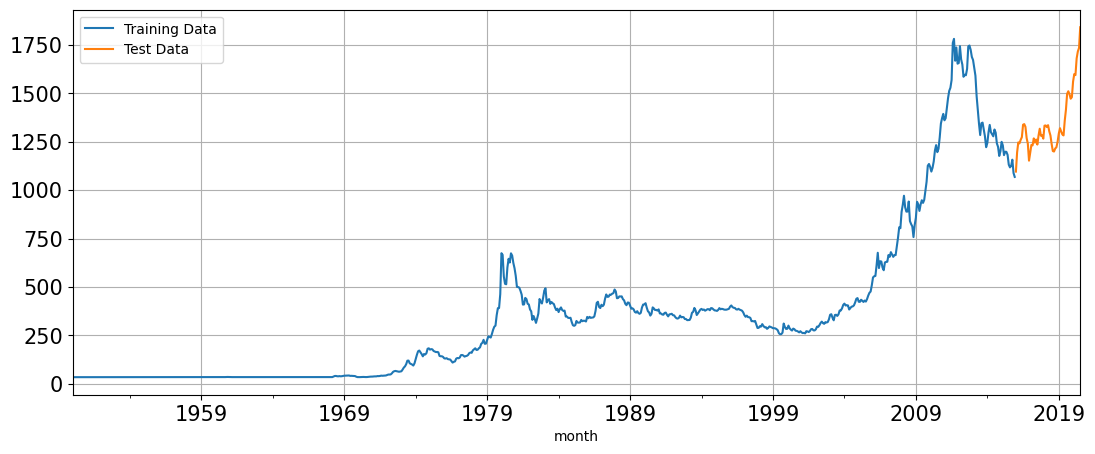

In [36]:
train["Price"].plot(figsize=(13,5), fontsize = 15)
test["Price"].plot(figsize=(13,5),fontsize = 15)
plt.grid()
plt.legend(['Training Data', 'Test Data'])
plt.show()

In [37]:
# Model Linear regression
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time), len(test_time)


(792, 55)

In [38]:
LR_train = train.copy()
LR_test = test.copy()


In [39]:
LR_train['time']= train_time
LR_test['time'] = test_time

In [41]:
lr = LinearRegression()
lr.fit(LR_train[['time']],LR_train["Price"].values)


LinearRegression()

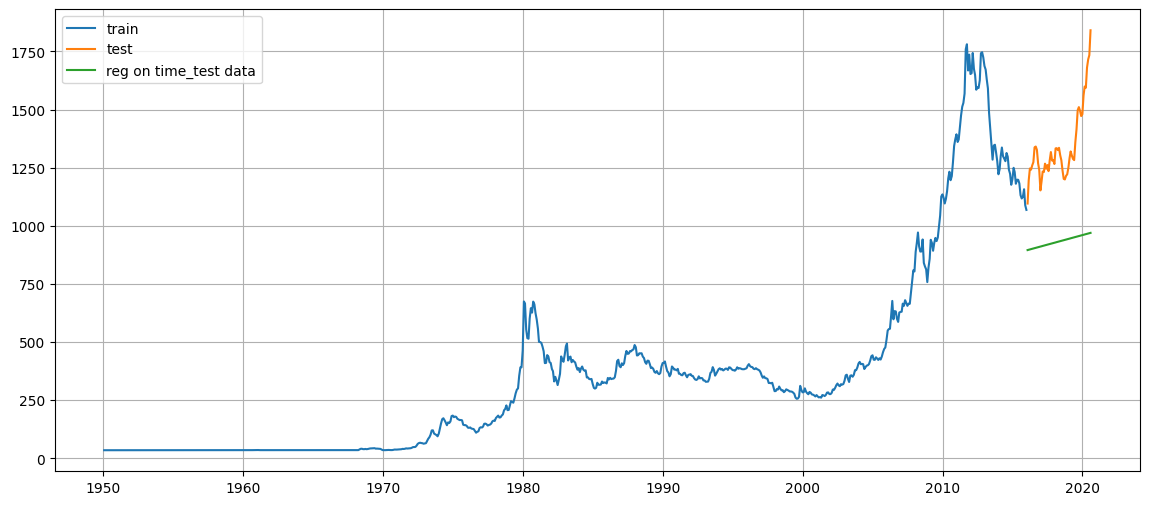

In [42]:
test_predictions_model1 = lr.predict(LR_test[["time"]])
LR_test['forecast'] = test_predictions_model1

plt.figure(figsize = (14,6))
plt.plot(train['Price'], label = 'train')
plt.plot(test["Price"],label='test')
plt.plot(LR_test['forecast'], label = 'reg on time_test data')
plt.legend(loc = 'best')
plt.grid();


In [43]:
def mape(actual, pred):
    return round((np.mean(abs(actual - pred) / actual))* 100, 2)


In [44]:
mape_model1_test = mape(test['Price'].values, test_predictions_model1)
print("Mape is %3.3f"% (mape_model1_test),"%")

Mape is 29.760 %


In [48]:
results = pd.DataFrame({'Test Mape (%)': [mape_model1_test]}, index=["RegressionOnTime"])
results

,Test Mape (%)
RegressionOnTime,29.76


### Naive pattern model

In [51]:
Naive_train = train.copy()
Naive_test = test.copy()

In [52]:
Naive_test['Naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['Naive'].head()


month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: Naive, dtype: float64

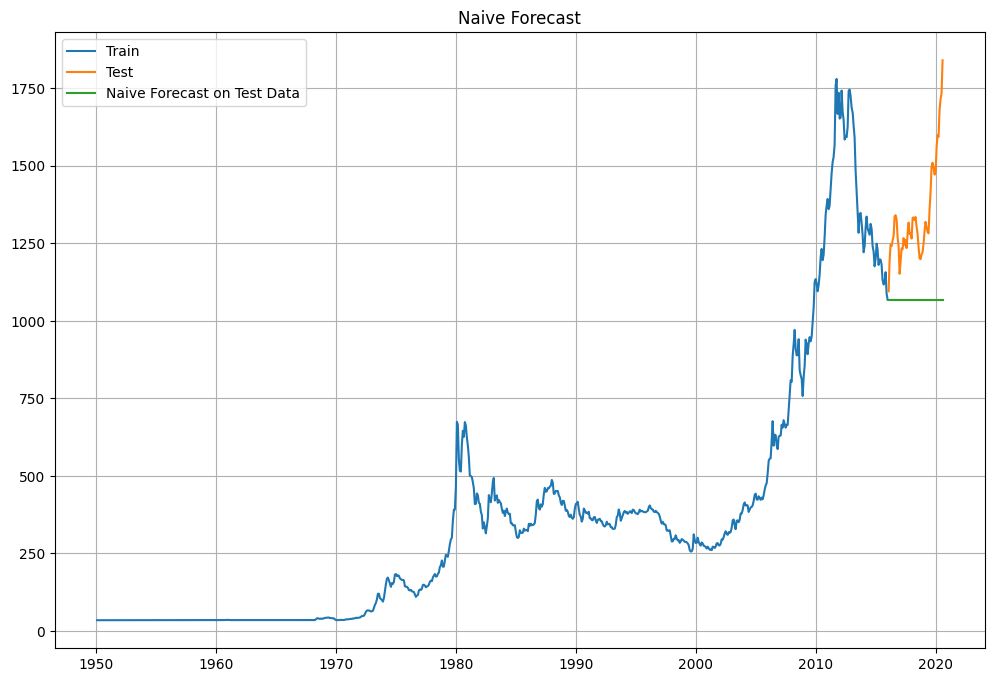

In [53]:
plt.figure(figsize= (12,8))
plt.plot(Naive_train['Price'], label= 'Train')
plt.plot(test['Price'], label = 'Test')
plt.plot(Naive_test['Naive'], label='Naive Forecast on Test Data')
plt.legend(loc= 'best')
plt.title("Naive Forecast")
plt.grid();


In [54]:
mape_model2_test = mape(test['Price'].values, Naive_test['Naive'].values)
print("For Naive Forcast on the Test Data, MAPE is %3.3f" %(mape_model2_test), "%")

For Naive Forcast on the Test Data, MAPE is 19.380 %


In [55]:
resultDf_2 = pd.DataFrame({'Test MAPE(%)': [mape_model2_test]}, index=['NaiveModel'])
results = pd.concat([results, resultDf_2])
results

,Test Mape (%),Test MAPE(%)
RegressionOnTime,29.76,NaN
NaiveModel,NaN,19.38


In [56]:
# Final forcasting
final_model = ExponentialSmoothing(df,
                                  trend= 'additive',
                                  seasonal ='additive').fit(smoothing_level = 0.4,
                                                            smoothing_trend = 0.3,
                                                            smoothing_seasonal = 0.6)

In [60]:
Mape_final_model = mape(df['Price'].values, final_model.fittedvalues)
print("Mape:", Mape_final_model)

Mape: 17.24


In [70]:
predictions = final_model.forecast(steps=len(test))

In [74]:
pred_df = pd.DataFrame({'lower_CI': predictions - 1.96*np.std(final_model.resid,ddof=1),
                        'prediction': predictions,
                        'upper_CI': predictions + 1.96*np.std(final_model.resid,ddof=1)})
pred_df.head()

,lower_CI,prediction,upper_CI
2020-08-31,1684.720065,1792.871037,1901.022009
2020-09-30,1615.306077,1723.457050,1831.608022
2020-10-31,1538.567922,1646.718895,1754.869867
2020-11-30,1476.758600,1584.909572,1693.060545
2020-12-31,1459.327290,1567.478262,1675.629235


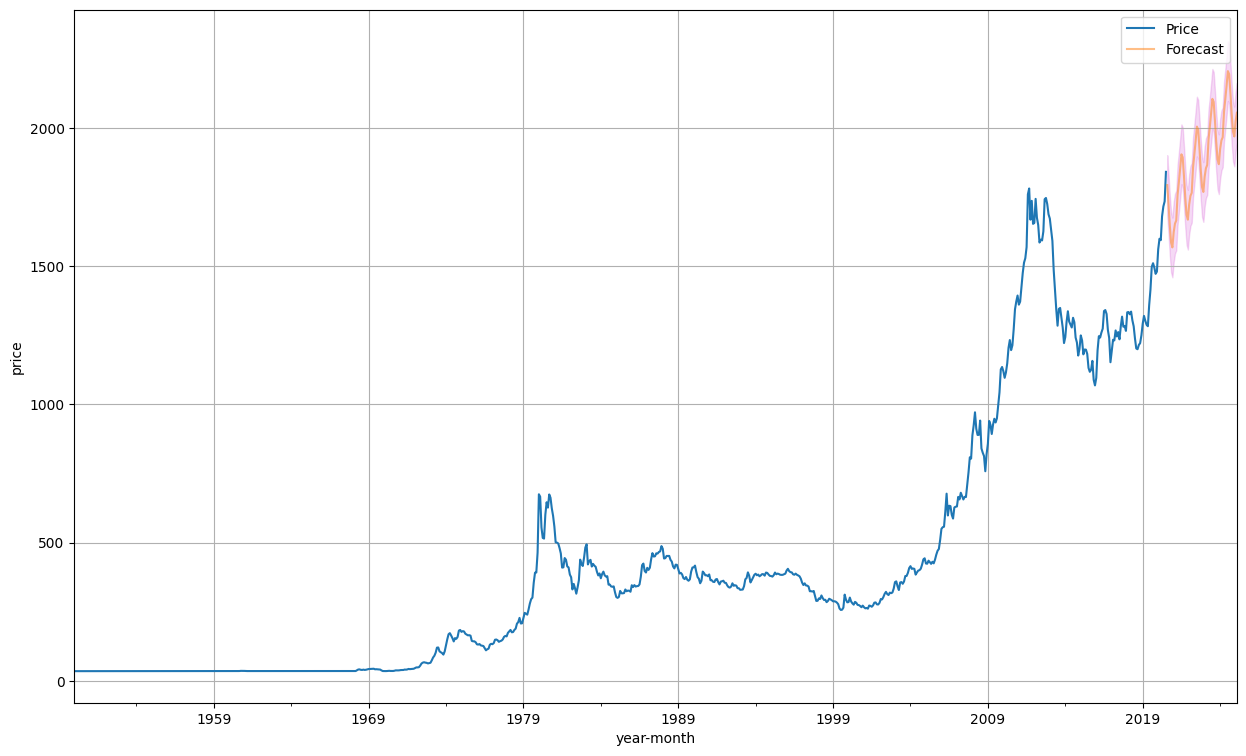

In [81]:
axis = df.plot(label = 'Actual', figsize=(15,9))
pred_df['prediction'].plot(ax= axis, label = 'Forecast', alpha = 0.5)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color = 'm', alpha = .15)
axis.set_xlabel('year-month')
axis.set_ylabel('price')
plt.legend(loc = 'best')
plt.grid()
plt.show()

